In [1]:
from pathlib import Path
import sys
relative_path = Path('model')
absolute_path = relative_path.resolve()
sys.path.append(str(absolute_path))

In [17]:
import torch
import pytorch_lightning as pl
from SGVB_SSM_TS_Clustering_Model_ResFlow import SGVB_SSM_TS_Clustering_Model_With_NF
from SIR_Toy_Dataset import SIR_Toy_Dataset, SIR_Sample_Dataset
from torch import optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FormatStrFormatter

In [18]:
base_param_dict_sir = {"input_dim":1,
                       "latent_dim":3,
                       "num_clusters":2,
                       "mode":"sir"}

lstm_param_dict = {"embed_hidden_dim":32,
                 "num_lstm_layers_base":2,
                 "num_lstm_layers_other":1,}

resflow_param_dict_sir = {"num_flow_module":4,
                      "kernel_size":2,
                      "dims" : [3, 32, 32, 32, 32, 3],
                      "bias" : True,
                      "coeff" : 0.9,
                      "n_iterations":None,
                      "tolerance":0.001,
                      "reduce_memory": False}


sir_model_param_dict={"c0":{"beta" : None,
                            "gamma" : None},
                      "c1":{"beta" : None,
                            "gamma" : None}}

sir_joint_prob_param_dict={"k_order" : None,
                           "lambda_order" : None,
                           "alpha_order" : None,
                           "init_SIR" : None}

trained_weight = "./weights/sir_trained_weight.pth"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [19]:
data_arr = np.load("data/sir_data.npz")
dataset = SIR_Toy_Dataset(data_arr, alldata=True)
dataloader = DataLoader(dataset, batch_size=45, shuffle=False)

sample_dataset = SIR_Sample_Dataset(data_arr)
sample_dataloader = DataLoader(sample_dataset, batch_size=2, shuffle=False)
sample_batch = next(iter(sample_dataloader))

In [20]:
model = SGVB_SSM_TS_Clustering_Model_With_NF(base_param_dict=base_param_dict_sir,
                                                lstm_param_dict=lstm_param_dict,
                                                resflow_param_dict=resflow_param_dict_sir,
                                                model_param_dict=sir_model_param_dict,
                                                joint_prob_param_dict=sir_joint_prob_param_dict,
                                                GPU = torch.cuda.is_available()).to(device)
model(sample_batch["I_obs"].to(device))
model.load_state_dict(torch.load(trained_weight))

<All keys matched successfully>

In [21]:
cluster_pred_list = []
cluster_gt_list = []
for batch in tqdm(dataloader):
    pred = model.lstm_embedder(batch["I_obs"].to(device))
    cluster_pred_list.append(np.argmax(pred["cluster"].cpu().detach().numpy(), axis=1))
    cluster_gt_list.append(batch["cluster"].numpy())
cluster_pred = np.concatenate(cluster_pred_list)
cluster_gt = np.concatenate(cluster_gt_list)

  0%|          | 0/14 [00:00<?, ?it/s]

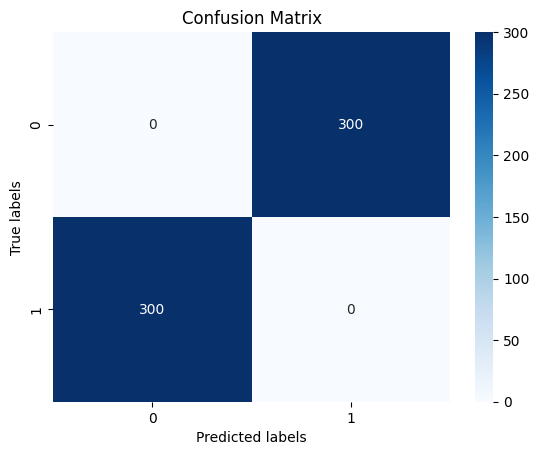

In [22]:
cm = confusion_matrix(cluster_gt, cluster_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
pred = model(sample_batch["I_obs"].to("cuda"))
pred_x = pred["z_logdet"]["z_norm"].to("cpu").detach().numpy()

I_obs = sample_batch["I_obs"]
I = sample_batch["I"]
S = sample_batch["S"]
R = sample_batch["R"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


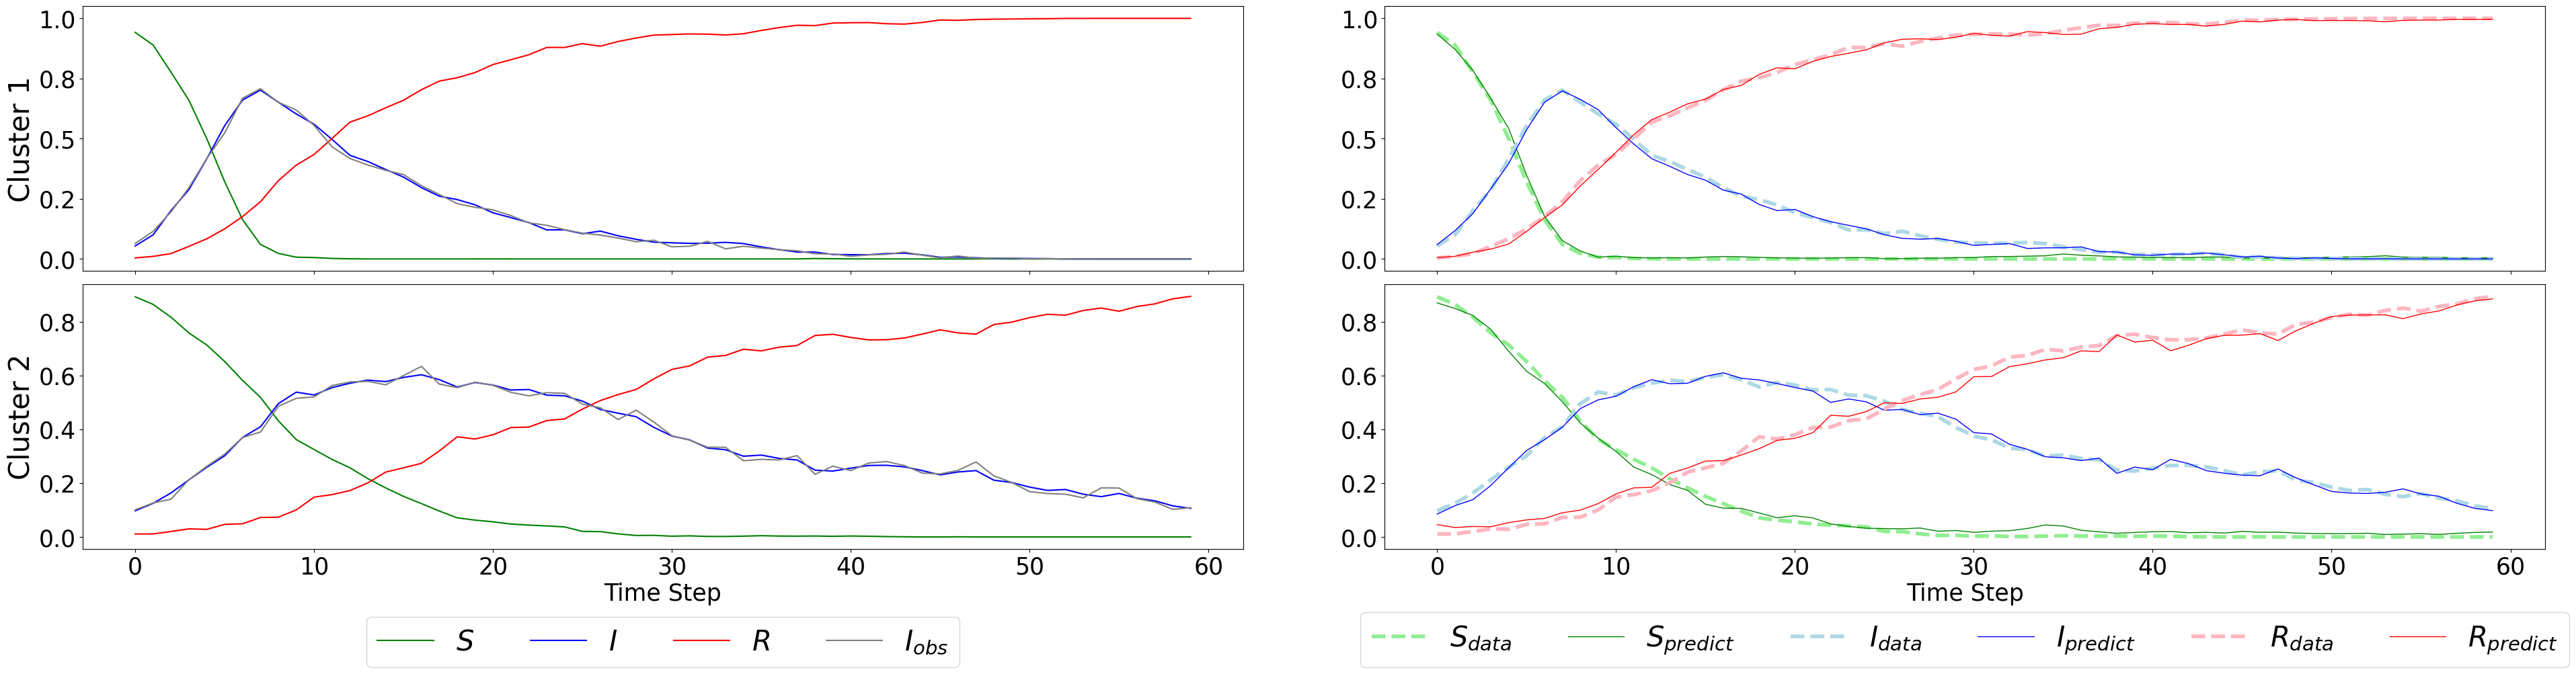

In [32]:
fig, axs = plt.subplots(2,2, figsize=(40, 10), sharex=True)
for i in range(2):
    
    axs[i,0].plot(S[i], label=r'$S$', c="green")
    axs[i,0].plot(I[i], label=r'$I$', c="blue")
    axs[i,0].plot(R[i], label=r'$R$', c="red")
    axs[i,0].plot(I_obs[i], label=r'$I_{obs}$', c="gray")
    axs[i,0].set_ylabel(f"Cluster {i+1}", fontsize=30)
    axs[i,0].tick_params(axis='both', which='major', labelsize=25)
    axs[i,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axs[i,0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=4, fontsize=30)
axs[i,0].set_xlabel("Time Step", fontsize=25)


axs[0,1].plot(S[0], label=r'$S_{data}$',linestyle="--",  c="lightgreen", linewidth=4)
axs[0,1].plot(pred_x[0][1][:,0], label=r'$S_{predict}$',linestyle="-",  c="green", linewidth=1)

axs[0,1].plot(I[0], label=r'$I_{data}$', linestyle="--",  c="lightblue", linewidth=4)
axs[0,1].plot(pred_x[0][1][:,1], label=r'$I_{predict}$',linestyle="-",  c="blue", linewidth=1)

axs[0,1].plot(R[0], label=r'$R_{data}$', linestyle="--",  c="lightpink", linewidth=4)
axs[0,1].plot(pred_x[0][1][:,2], label=r'$R_{predict}$',linestyle="-",  c="red", linewidth=1)
axs[0,1].tick_params(axis='both', which='major', labelsize=25)

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[0,1].tick_params(axis='both', which='major', labelsize=25)




axs[1,1].plot(S[1], label=r'$S_{data}$',linestyle="--",  c="lightgreen", linewidth=4)
axs[1,1].plot(pred_x[1][0][:,0], label=r'$S_{predict}$',linestyle="-",  c="green", linewidth=1)

axs[1,1].plot(I[1], label=r'$I_{data}$', linestyle="--",  c="lightblue", linewidth=4)
axs[1,1].plot(pred_x[1][0][:,1], label=r'$I_{predict}$',linestyle="-",  c="blue", linewidth=1)

axs[1,1].plot(R[1], label=r'$R_{data}$', linestyle="--",  c="lightpink", linewidth=4)
axs[1,1].plot(pred_x[1][0][:,2], label=r'$R_{predict}$',linestyle="-",  c="red", linewidth=1)
axs[1,1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=6, fontsize=30)

axs[1,1].tick_params(axis='both', which='major', labelsize=25)
axs[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
axs[1,1].set_xlabel("Time Step", fontsize=25)
plt.subplots_adjust(hspace=0.1)  # hspaceを小さくすることで行間を詰める
plt.tight_layout()

plt.savefig("fig/sir_all.pdf", format='pdf', bbox_inches='tight')
plt.savefig("fig/sir_all.eps", format='eps', bbox_inches='tight')